In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Data on Total mortality is provided by ISCiii -- the "Instituto de Salud Carlos the 3rd" (a public health research institute part of EuroMOMO https://www.euromomo.eu/). The total mortality data can be accessed here: https://momo.isciii.es/public/momo/dashboard/momo_dashboard.html#datos . These data are constantly updated. We always download the data from this website, add the download date to the file name and .zip it before we push it to the repo. 

- Covid-19 mortality is also provided by ISCIiii: https://covid19.isciii.es/ . Bottom left corner $\to$ "Si desea descargarse los datos pulse aquí." 

**IMPORTANT** The total mortality data for Spain only go back to 2018-03-28. Since the first Covid-19 death occurred on 2020-03-08, we would ideally need data for 2015-2019 from at least March 7th onwards. This means that for Spain, **we can construct the countefactual based on 2019 data only. We therefore view this as a purely exploratory exercise** and hope that ISCiii will make historical all-cause mortality data that go further back available in the near future. Should this happen, we will update this analysis.

# 1) Parsing the data on total death

In [2]:
df = pd.read_csv('./total_death/data_2020_04_15.zip')
df['fecha_defuncion']  =  pd.to_datetime(df['fecha_defuncion'] , format='%Y%m%d', errors='ignore')

We carry out two consistency checks on the data

- We check whether the data for the individual regions add up to the national total

- We examine the time series for each region to "eyeball" when reporting delay becomes so severe that the series become unusable. Crucially (and unfortunately) different regions may suffer from different degrees of reporting delays and so the last usable day for the national data is the day before the first day in which the first region becomes unusable because of reporting delay. 

## 1.1) Checking whether regions add up to national data

In [3]:
nat = df[(df.ambito == 'nacional') & 
         (df.nombre_sexo == 'todos') & 
         (df.nombre_gedad == 'todos')]\
        [['fecha_defuncion', 'defunciones_observadas']]\
        .reset_index(drop=True).copy(deep=True)
nat.columns = ['date', 'deaths_national']

In [4]:
reg = df[(df.ambito == 'ccaa') & 
         (df.nombre_sexo == 'todos') & 
         (df.nombre_gedad == 'todos')]\
        [['fecha_defuncion', 'defunciones_observadas', 'cod_ambito', 'nombre_ambito']]\
        .reset_index(drop=True).copy(deep=True)
reg.columns = ['date', 'deaths', 'region_code', 'region_name']
rgb = reg[['date', 'deaths']].groupby('date').sum().reset_index(drop=False).copy(deep=True)
rgb.columns = ['date', 'deaths_regions_nationaltotal']

In [5]:
check = pd.merge(nat, rgb, on='date', how='outer', indicator=True)
print(check._merge.value_counts())
del check['_merge']
check['discrepancy'] = check.deaths_national - check.deaths_regions_nationaltotal

both          749
right_only      0
left_only       0
Name: _merge, dtype: int64


In [6]:
check[check.discrepancy != 0]

,date,deaths_national,deaths_regions_nationaltotal,discrepancy
721,2020-03-18,1421,1419,2
722,2020-03-19,1565,1564,1
723,2020-03-20,1727,1726,1
724,2020-03-21,1818,1816,2
725,2020-03-22,1719,1718,1
726,2020-03-23,1913,1912,1
727,2020-03-24,2153,2152,1
728,2020-03-25,2241,2240,1
729,2020-03-26,2264,2263,1
730,2020-03-27,2391,2390,1


**Conclusion**: there are negligible differences between totals arrived at from regional data and using national data directly and only from 2020-03-18 forward. This seems fine to ignore.

## 1.2 Examining the extent of reporting delays by region

In [7]:
rdbyreg = reg[reg.date >= '2020-03-20'].reset_index(drop=True).copy(deep=True)
rdbyreg.index = rdbyreg.date

The following graph plots daily number of deaths by region and also a vertical line on 2020-04-01. This will be our cutoff date after which the data seem start suffering from under-reporting. 

Note from here https://momo.isciii.es/public/momo/dashboard/momo_dashboard.html#notificacion, panel "Retraso en la notificación" that currently (2020-04-15), 90% of deaths have less than or equal to 12 days of registration delay (just how ISCiii arrives at this 90% is not quite clear). We think that by going to 14 days, we are being cautious.

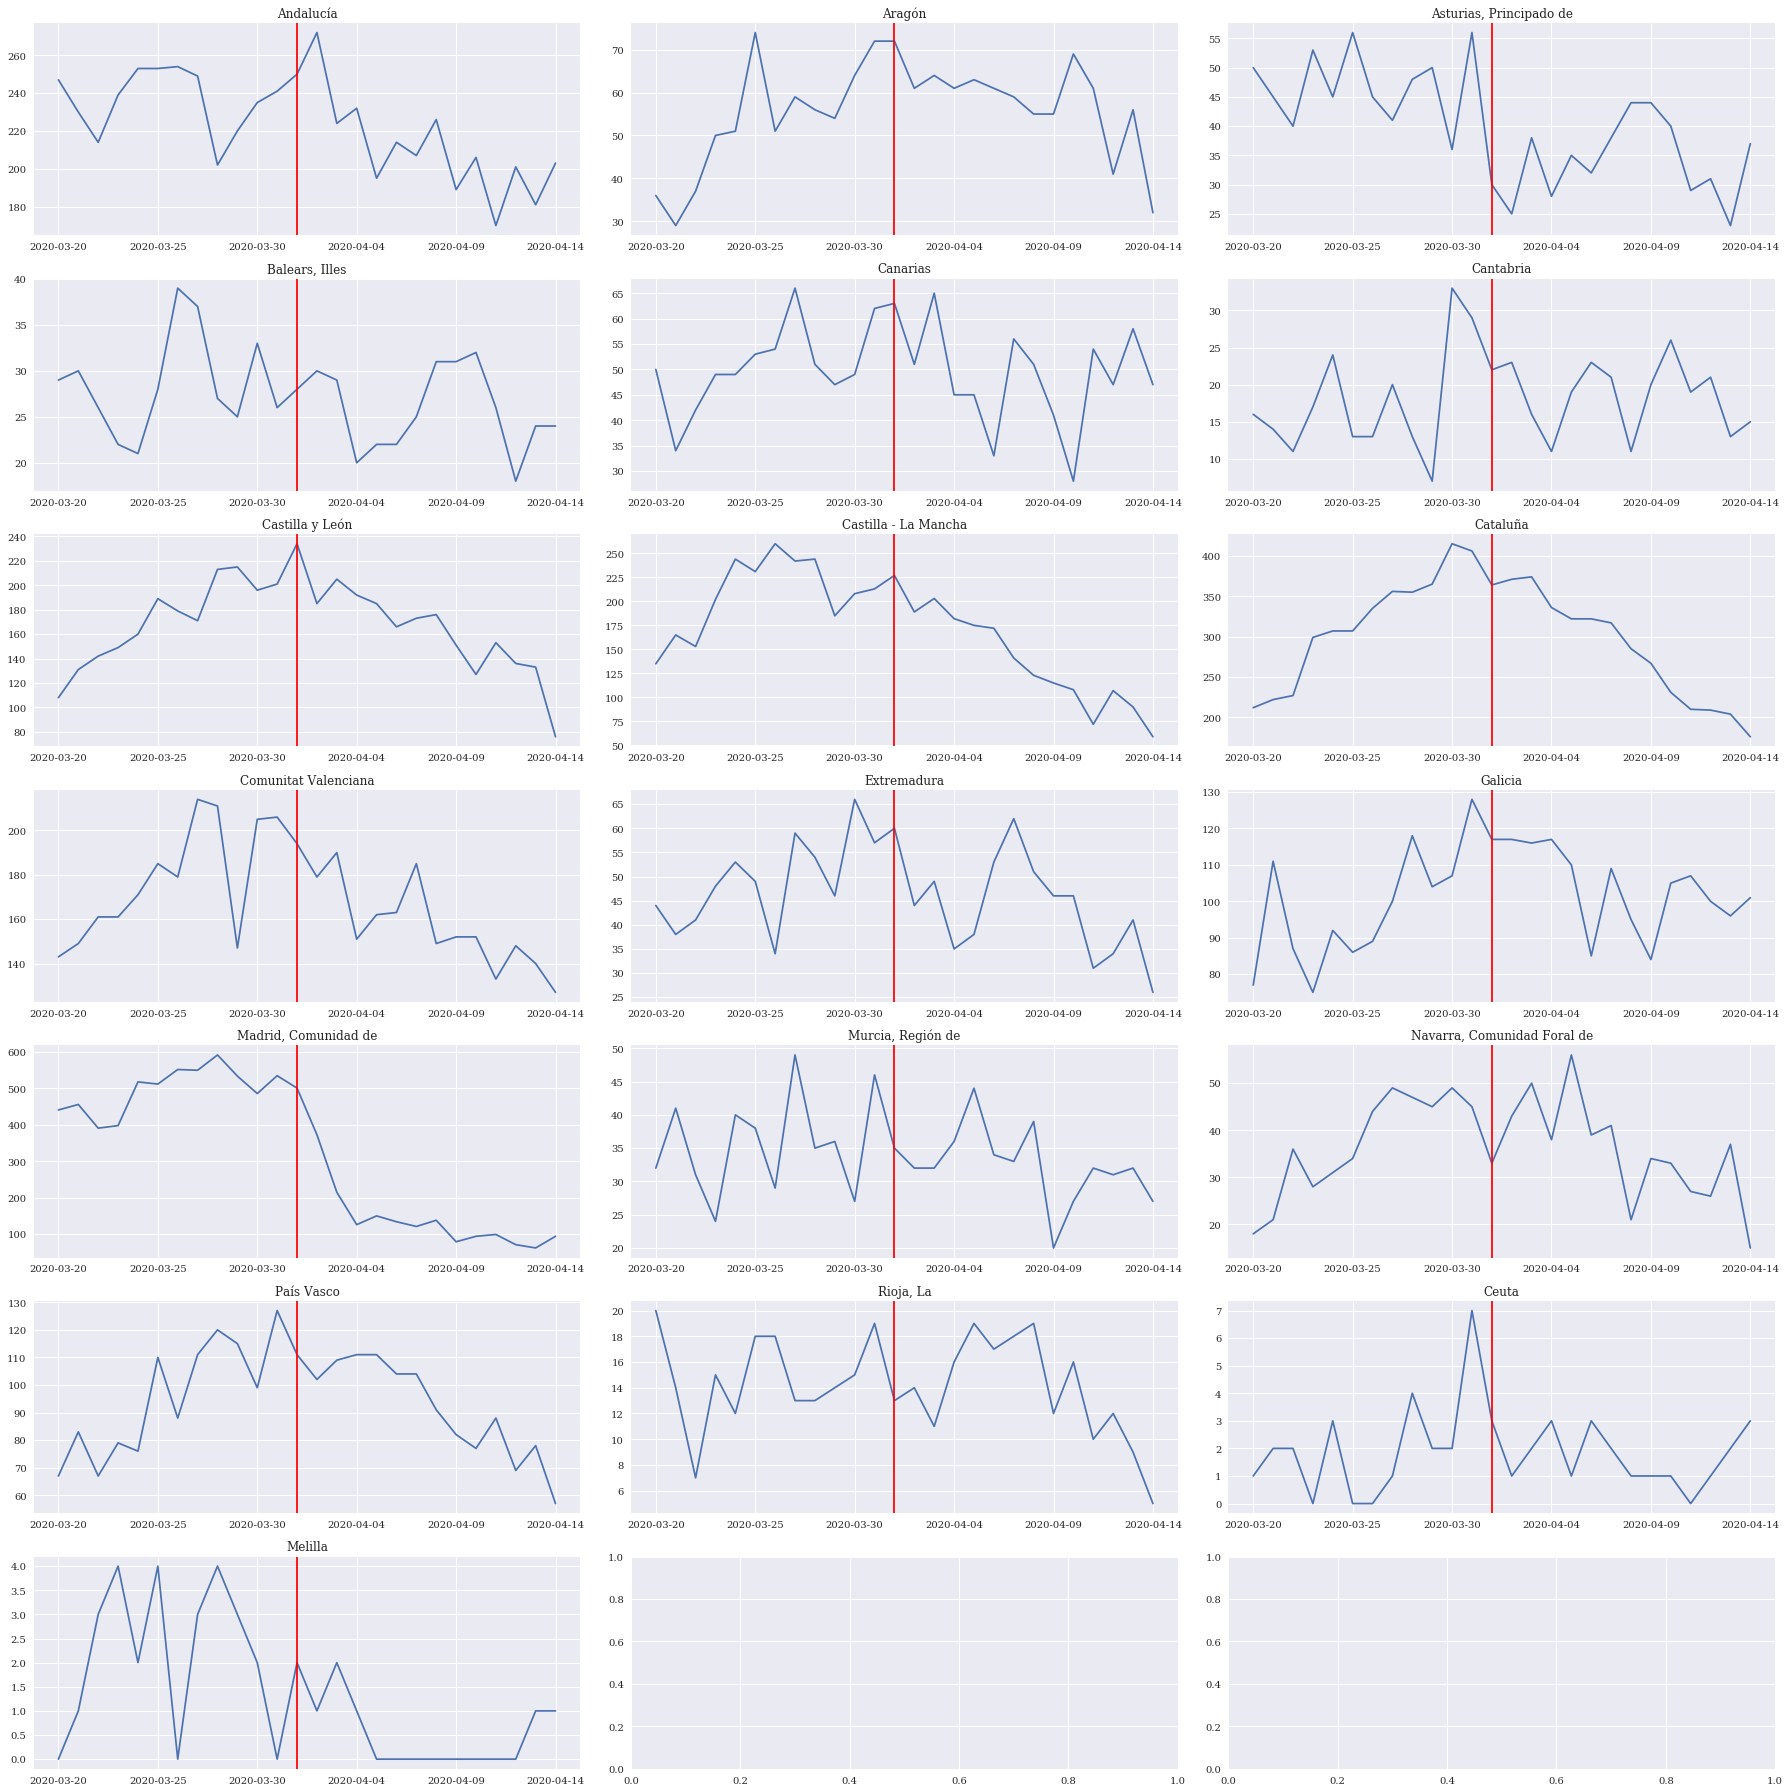

In [8]:
rows = 7
cols = 3
f, ax = plt.subplots(7, 3, figsize=(25, 25))
row = 0
col = 0
for idx, reg_name in enumerate(rdbyreg.region_name.unique()):
    ax[row, col].plot(rdbyreg[rdbyreg.region_name == reg_name].index, rdbyreg[rdbyreg.region_name == reg_name].deaths)
    ax[row, col].set_xticks(rdbyreg[rdbyreg.region_name == reg_name].index[[0,5,10,15,20,25]])
    ax[row, col].set_title(reg_name)
    ax[row, col].axvline(x=np.argwhere(rdbyreg.index=='2020-04-01')[0][0], color='r')
    if col == 2:
        col = 0
        row += 1
    else:
        col+= 1
plt.tight_layout()
plt.show()

In [9]:
nat = nat[nat.date <= '2020-04-01']
nat['day'] = nat.date.str[-2:]
nat['month'] = nat.date.str[5:7:]
nat['year'] = nat.date.str[:4]

for yr in range(2018, 2021):
    df_y = nat[nat.year == '{}'.format(yr)]\
    [['deaths_national', 'day', 'month']].reset_index(drop=True).copy(deep=True)
    df_y.columns = ['{}'.format(yr), 'day', 'month']
        
    if yr == 2018:
        df = df_y
    else:
        df = pd.merge(df, df_y, on=['day', 'month'], how='outer')
df = df[['day', 'month', '2018', '2019', '2020']]\
     .sort_values(['month', 'day'])
df = df[~pd.isnull(df['2020'])].reset_index(drop=True).copy(deep=True)

2018 data start only on March 28th $\to$ remove 2018

In [10]:
df[~pd.isnull(df['2018'])]

,day,month,2018,2019,2020
87,28,03,1179.0,1142.0,2409.0
88,29,03,1168.0,1110.0,2216.0
89,30,03,1156.0,1132.0,2328.0
90,31,03,1059.0,1046.0,2476.0
91,01,04,1103.0,1113.0,2359.0


In [11]:
del df['2018']

restricting data to March 7th (day BEFORE first Covid-death) onwards

In [12]:
df['date'] = '2020-' + df.month + '-' + df.day
df = df[df.date >= '2020-03-07'][['date', '2019', '2020']].reset_index(drop=True).copy(deep=True)

computing cumulative sums

In [13]:
for yr in range(2019, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

computing growth rate for 2019 only

In [14]:
for yr in range(2019, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

extrapolating 2020 forward based on 2019 growth rate

In [15]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.date=='2020-03-07','cs_2020'].values[0]

In [16]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'gr_2019']

In [17]:
df = df.drop(['gr_2019'], axis=1)

# 2) Processing the Covid-19 data

In [18]:
official = pd.read_csv('./covid_deaths/serie_historica_acumulados.csv', encoding = "ISO-8859-1")
print(len(official[~pd.isnull(official.FECHA)].CCAA.unique()))
official = official[~pd.isnull(official.FECHA)][['FECHA', 'Fallecidos']]
official = official.fillna(0)
official = official.groupby('FECHA').sum().reset_index(drop=False)
official['day'] = ('0' + official.FECHA.apply(lambda x: re.search('([0-9]+).+', x).group(1))).str[-2:]
official['month'] = ('0' + official.FECHA.apply(lambda x: re.search('([0-9]+)/([0-9]+).+', x).group(2))).str[-2:]
official['date'] = '2020-' + official.month + '-' + official.day
official['covid_deaths'] = official.Fallecidos
official['date']  =  pd.to_datetime(official['date'] , format='%Y%m%d', errors='ignore')
official = official[['date', 'covid_deaths']]\
                    [official.covid_deaths > 0]\
                    .sort_values('date').reset_index(drop=True).copy(deep=True)

19


# 3) Merging and plotting

In [19]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
del df['covid_deaths']
df.index = df.date
del df['date']

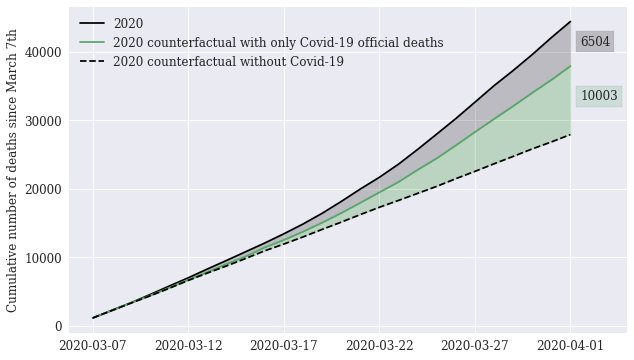

In [20]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[0,5,10,15,20,25]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since March 7th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 1.7

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(25.5, 33000, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(25.5, 41000, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_spain.pdf', bbox_inches='tight', dpi=100)

In [21]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 10003.0 = green - dashed black
Excess deaths: 16507.0 = solid black - dashed black
Unexplained excess deaths: 6504.0 = solid black - green
